# Goal
make code SIMPLER

It seems to be a pressure problem

Now, we assume:
- $\Delta n = \Delta m$

## Definitions

In [1]:
from __future__ import annotations

from dataclasses import dataclass


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from ipywidgets import *
from IPython.display import display
import napari
from tqdm import tqdm




class CFDResult:
    def __init__(self, all_u: np.array, simu: CFDSimulation):
        self.all_u = all_u
        self.simu = simu
        self.all_norms = np.linalg.norm(all_u, axis=3)

    def plot_velocities(self, constant_scale=False):
        viewer = napari.view_image(self.all_norms)
        napari.run()
    
            
    def plot_divergences(self):
        return
        def update(step = (0, self.all_u.shape[0] - 1, 1)):
            div = simu.compute_divergence(self.all_u[step])
            plt.imshow(div)
            plt.colorbar()
            plt.show()
        return interact(update)

    def energy_over_time(self):
        fig, ax = plt.subplots()
        # We use a proxy formula for energy defined as sum of squared norm of velocities
        # all_u of shape [S, N, M, 2]
        energy = (self.all_u ** 2).sum(axis=(1, 2, 3))
        ax.plot(list(range(len(energy))), energy)
        ax.set_title("Proxy energy over time")
        plt.show()

    def re_over_time(self):
        fig, ax = plt.subplots()
        # all_u of shape (S, N, M, 2)
        re_t = np.sqrt(np.mean((self.all_u ** 2).sum(axis=(3)) ** 2, axis=(1, 2))) * self.simu.grid_size[0] / self.simu.nu
        ax.plot(list(range(len(re_t))), re_t)
        ax.set_title("Re over time")
        plt.show()

class CFDSimulation:
    def __init__(self):
        self.steps = 15
        self.dt = 0.1
        self.grid_size = (1, 1)
        self.N = 32
        self.M = 32
        self.dn = self.grid_size[0] / self.N
        self.dm = self.grid_size[1] / self.M
        self.dim = (self.N, self.M, 2)
        self.initial_u = np.random.sample(size=self.dim)
        self.u_rms = np.sqrt(np.mean(self.initial_u ** 2))
        self.re = 200
        self.nu = (self.u_rms * self.grid_size[0]) / self.re
        # print(f'Using nu={nu} for target re:{re} (u rms: {u_rms})')
        self.rho = 1
        self.p = np.zeros(self.dim)


    def fetcher(self, field, pad_value = 0):
        def _intern(n, m, component):
            if n < 0 or n >= self.N or m < 0 or m >= self.M: return pad_value
            return field[n, m, component]
        return _intern
    
    def compute_convection(self, u_in):
        convection = np.zeros_like(u_in)
    
        def derivative(loc, axis, component):
            prev_pt = np.clip(loc - axis, 0, [self.N - 1, self.M - 1])
            next_pt = np.clip(loc + axis, 0, [self.N - 1, self.M - 1])
            return (u_in[*next_pt, component] - u_in[*prev_pt, component]) / (2 * self.dn)
            
        uf = self.fetcher(u_in)
        d = 2 * self.dn
        
        for n in range(self.N):
            for m in range(self.M):
                grads = np.array([
                    [(uf(n + 1, m, 0) - uf(n - 1, m, 0)) / d, (uf(n + 1, m, 1) - uf(n - 1, m, 1)) / d], 
                    [(uf(n, m + 1, 0) - uf(n, m - 1, 0)) / d, (uf(n, m + 1, 1) - uf(n, m - 1, 1)) / d]])
                convection[n, m] = np.dot(u_in[n, m], grads)
                
        return convection

    def compute_viscous_drag(self, u_in):
        viscous_drag = np.zeros_like(u_in)
        
        uf = self.fetcher(u_in)
        cell_dist = 1
        d = (cell_dist * self.dn) ** 2
       
        for n in range(self.N):
            for m in range(self.M):
                for component in range(2):
                    viscous_drag[n, m, component] = uf(n + cell_dist, m, component) - 2 * uf(n, m, component) - uf(n - cell_dist, m, component) 
                    + uf(n, m  + cell_dist, component) - 2 * uf(n, m, component) - uf(n, m - cell_dist, component)
                    viscous_drag[n, m, component] /= d
        return viscous_drag * self.nu
        
                # (N,M,1) -> (N,M,2)
    def compute_pressure(self, pressure_in):
        pressure_out = np.zeros_like(self.initial_u)
        
        def derivative(loc, axis):
            prev_pt = np.clip(loc - axis, 0, [self.N - 1, self.M - 1])
            next_pt = np.clip(loc + axis, 0, [self.N - 1, self.M - 1])
            return (pressure_in[*next_pt, 0] - pressure_in[*prev_pt, 0]) / (2 * self.dn)
            
        for n in range(self.N):
            for m in range(self.M):
                pressure_out[n, m, 0] = derivative(np.array([n, m]), np.array([1, 0]))
                pressure_out[n, m, 1] = derivative(np.array([n, m]), np.array([0, 1]))
        
        return (1 / self.rho) * pressure_out

    def compute_updated_pressure(self, p_in, inter_u_in):
        p2 = np.zeros_like(p_in)
        
        def fetch(source, mock):
            def fetch_intern(n, m):
                if n < 0 or n >= self.N:
                    return mock
                if m < 0 or m >= self.M:
                    return mock
                return source[n, m]
            return fetch_intern
        
        fetch_p = fetch(p_in, 0)
        fetch_u = fetch(inter_u_in, 0)
        cell_dist = 1
        for n in range(self.N):
            for m in range(self.M):
                rnm = self.rho / self.dt * ((fetch_u(n, m) - fetch_u(n - 1, m)) / self.dn) + (fetch_u(n, m) - fetch_u(n, m - 1)) / (2 * self.dm)
                x = (fetch_p(n + cell_dist, m) - fetch_p(n - cell_dist, m)) * 4 * self.dm ** 2 + (fetch_p(n, m + cell_dist) - fetch_p(n, m - cell_dist)) * 4 * self.dn ** 2
                x -= rnm * 16 * self.dn ** 2 * self.dm ** 2
                x /= 8 * (self.dn ** 2 + self.dm ** 2)
                p2[n, m] = x
    
        return self.compute_pressure(p2)

    def compute_divergence(self, u_in):
        divergence = np.zeros((self.N, self.M))
        bc = 0
        def fetch(n, m, c):
            if n < 0 or n >= self.N or m < 0 or m >= self.M:
                return bc
            return u_in[n, m, c]
            
        for n in range(self.N):
            for m in range(self.M):
                divergence[n, m] = (fetch(n + 1, m, 0) - fetch(n - 1, m, 0)) / (2 * self.dn) + (fetch(n, m + 1, 1) - fetch(n, m - 1, 1)) / (2 * self.dn)
        return divergence

    def launch(self):
        all_u = np.zeros((self.steps, self.N, self.M, 2))
        all_u[0] = self.initial_u
        for step in tqdm(range(1, self.steps)):
            conv = self.compute_convection(all_u[step - 1])
            visc = self.compute_viscous_drag(all_u[step - 1])
            u_update = -conv + visc
            inter_u = all_u[step - 1] + u_update * self.dt
            self.p = self.compute_updated_pressure(self.p, inter_u)
            all_u[step] = inter_u
            # print(f"[Step {step}] u mean: {all_u[step].mean():.2f}, conv: {conv.mean():.2f}, visc: {visc.mean():.2f}, u_up mean: {u_update.mean():.2f},  inter u mean: {inter_u.mean():.2f} new pressure mean: {self.p.mean():.2f}")
        return CFDResult(all_u, self)

## Runs

In [9]:

simu = CFDSimulation()
simu.dt = 1e-4
simu.re = 200
result = simu.launch()
np.save(result.



100%|███████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 18.28it/s]


In [10]:
%gui qt6
viewer = napari.Viewer()
viewer.add_image(result_1em4.all_norms, name="dt:1e-4")

<Image layer 'dt:1e-4' at 0x795ca077fb60>

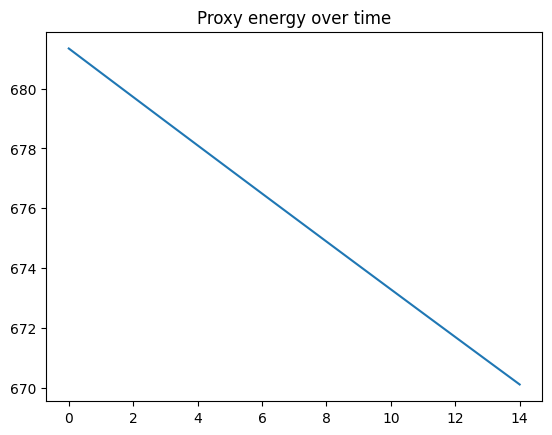

In [11]:
result_1em4.energy_over_time()